In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from BandDeepHitSingle import BandedDeepHitSingle
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [5]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
num_durations = 10
labtrans = BandedDeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [8]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [9]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

## 在这里修改alpha=[0.1,0.2,0.3,0.4,0.5]和sigma=[0.1]

In [10]:
model = BandedDeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

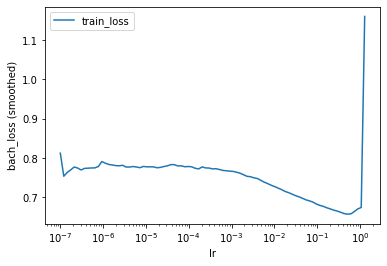

In [11]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [12]:
lr_finder.get_best_lr()

0.050941380148164093

In [13]:
model.optimizer.set_lr(lr_finder.get_best_lr())

In [14]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.8039,	val_loss: 0.6343
1:	[0s / 0s],		train_loss: 0.6224,	val_loss: 0.6044
2:	[0s / 0s],		train_loss: 0.5756,	val_loss: 0.5437
3:	[0s / 0s],		train_loss: 0.5540,	val_loss: 0.5216
4:	[0s / 0s],		train_loss: 0.5389,	val_loss: 0.5216
5:	[0s / 0s],		train_loss: 0.5219,	val_loss: 0.5035
6:	[0s / 0s],		train_loss: 0.5175,	val_loss: 0.4919
7:	[0s / 0s],		train_loss: 0.5071,	val_loss: 0.4945
8:	[0s / 0s],		train_loss: 0.5083,	val_loss: 0.4871
9:	[0s / 0s],		train_loss: 0.4963,	val_loss: 0.4875
10:	[0s / 0s],		train_loss: 0.4969,	val_loss: 0.4846
11:	[0s / 0s],		train_loss: 0.4913,	val_loss: 0.4866
12:	[0s / 0s],		train_loss: 0.4911,	val_loss: 0.4804
13:	[0s / 0s],		train_loss: 0.4903,	val_loss: 0.4836
14:	[0s / 0s],		train_loss: 0.4848,	val_loss: 0.4844
15:	[0s / 0s],		train_loss: 0.4852,	val_loss: 0.4843
16:	[0s / 0s],		train_loss: 0.4821,	val_loss: 0.4800
17:	[0s / 0s],		train_loss: 0.4850,	val_loss: 0.4829
18:	[0s / 0s],		train_loss: 0.4810,	val_loss: 0.4825
19:

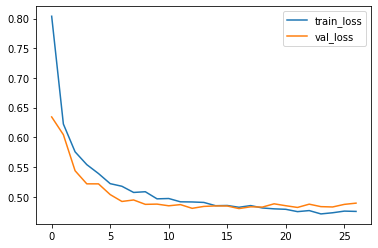

In [15]:
_ = log.plot()

In [16]:
surv = model.predict_surv_df(x_test)

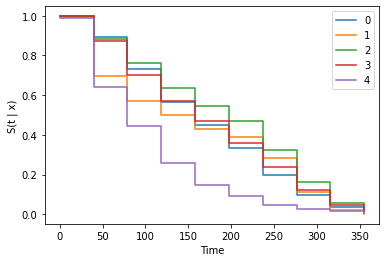

In [17]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [18]:
surv = model.interpolate(10).predict_surv_df(x_test)

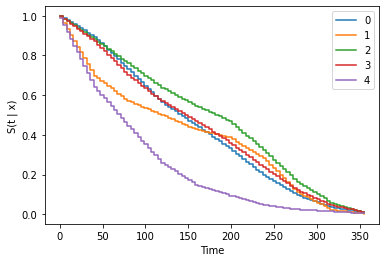

In [19]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [21]:
ev.concordance_td('antolini')

0.6776887532324388

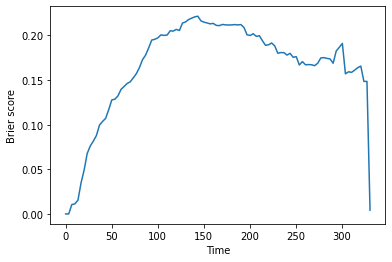

In [22]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

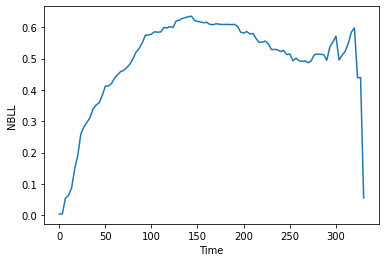

In [23]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [24]:
ev.integrated_brier_score(time_grid) 

0.16593645621320652

In [25]:
ev.integrated_nbll(time_grid) 

0.4977930616780328